 # Airline Passenger Timeseries Forecasting

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow.keras as ks

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

np.random.seed(9)

In [29]:
df = pd.read_csv("/content/airline-passengers.csv", usecols=[1], engine="python")
df.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [30]:
dataset = df.values.astype("float32")

In [31]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [32]:
dataset.shape

(144, 1)

In [33]:
# split data
dataset_size =len(dataset)
train_size = int(dataset_size*0.67)
test_size = dataset_size - train_size

train, test = dataset[:train_size, :],dataset[train_size: dataset_size, :]

print(len(train), len(test))

96 48


In [34]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [],[]

  dsize =  len(dataset)

  for i in range(dsize - look_back-1):
    a = dataset[i: (i+look_back),0]
    dataX.append(a)
    dataY.append(dataset[(i+look_back),0])

  return np.array(dataX), np.array(dataY)

In [35]:
# reshape into X=t and Y=t+1

look_back=1

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [36]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [37]:
# create and fit the LSTM network
model = ks.models.Sequential()
model.add(ks.layers.LSTM(4, input_shape=(1, look_back)))
model.add(ks.layers.Dense(1))

model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)

model.fit(
    trainX, trainY, epochs=100, batch_size=1, verbose=2
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 - 2s - 23ms/step - loss: 0.0412
Epoch 2/100
94/94 - 0s - 3ms/step - loss: 0.0201
Epoch 3/100
94/94 - 0s - 3ms/step - loss: 0.0148
Epoch 4/100
94/94 - 0s - 3ms/step - loss: 0.0137
Epoch 5/100
94/94 - 0s - 3ms/step - loss: 0.0129
Epoch 6/100
94/94 - 0s - 3ms/step - loss: 0.0120
Epoch 7/100
94/94 - 1s - 6ms/step - loss: 0.0111
Epoch 8/100
94/94 - 0s - 2ms/step - loss: 0.0102
Epoch 9/100
94/94 - 0s - 2ms/step - loss: 0.0093
Epoch 10/100
94/94 - 0s - 3ms/step - loss: 0.0084
Epoch 11/100
94/94 - 0s - 3ms/step - loss: 0.0077
Epoch 12/100
94/94 - 0s - 3ms/step - loss: 0.0067
Epoch 13/100
94/94 - 0s - 3ms/step - loss: 0.0059
Epoch 14/100
94/94 - 0s - 3ms/step - loss: 0.0053
Epoch 15/100
94/94 - 0s - 3ms/step - loss: 0.0045
Epoch 16/100
94/94 - 0s - 3ms/step - loss: 0.0039
Epoch 17/100
94/94 - 0s - 3ms/step - loss: 0.0035
Epoch 18/100
94/94 - 0s - 2ms/step - loss: 0.0031
Epoch 19/100
94/94 - 0s - 3ms/step - loss: 0.0028
Epoch 20/100
94/94 - 0s - 3ms/step - loss: 0.0026
Epoch 21/100
94/94 -

In [38]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [39]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [40]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

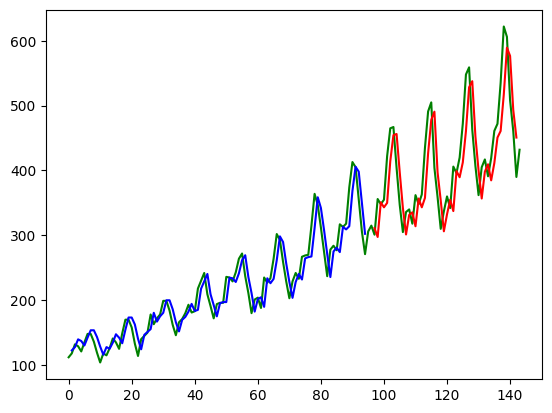

In [41]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), color="green")
plt.plot(trainPredictPlot, color='blue',)
plt.plot(testPredictPlot, color='red',)
plt.show()